## The Spectrogram

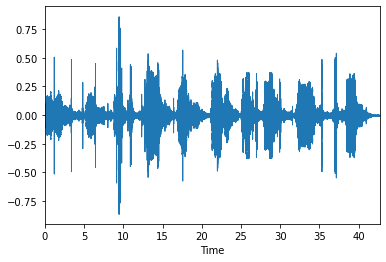

In [2]:
import librosa
import librosa.display

filename = './Haunting_song_of_humpback_whales.wav'
y, sr = librosa.load(filename)
# trim silent edges
whale_song, _ = librosa.effects.trim(y)
librosa.display.waveplot(whale_song, sr=sr)

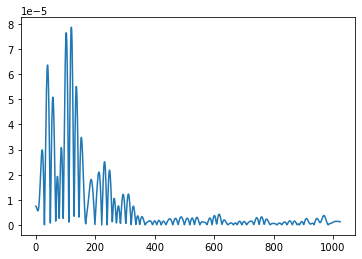

In [3]:
import numpy as np
import matplotlib.pyplot as plt

n_fft = 2048
D = np.abs(librosa.stft(whale_song[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
plt.plot(D)

Now let's take the complete whale song, seperate it to time windows, and apply the Fourier Transform on each time window.

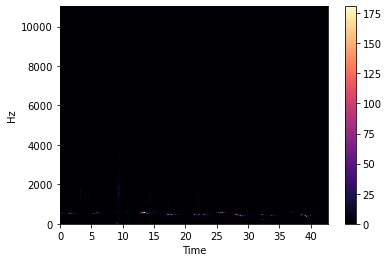

In [4]:
hop_length = 512
D = np.abs(librosa.stft(whale_song, n_fft=n_fft, hop_length=hop_length))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()

Wow can't see much here can we? It's because most sounds humans hear are concentrated in very small frequency and amplitude ranges.

Let's make another small adjustment-transform both the y-axis(frequency) to log scale, and the 'color' axis(amplitude) to Decibels, which is kinda the log scale of amplitude.

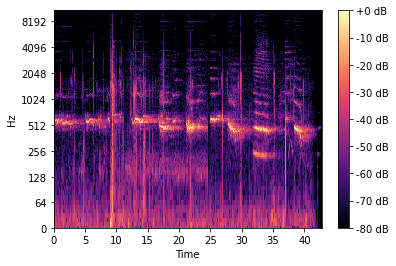

In [5]:
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')

Now this is what we call a Spectrogram!

### The Mel Scale

Mel scale(梅尔标度):人耳能听到的频率范围是20-20000Hz，但人耳对Hz这种标度单位并不是线性感知关系   

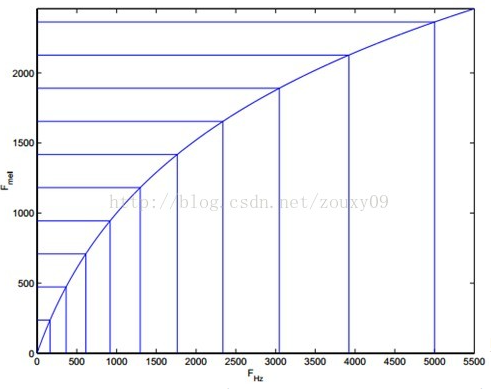

让我们观察一下从Hz到mel的映射图，由于是log的关系，当频率较小时，mel随Hz变化较快；当频率很大时，mel的上升很缓慢，曲线的斜率很小。这说明了**人耳对低频音调的感知较灵敏，在高频时人耳是很迟钝的**。如果将普通的频率标度转化为梅尔频率标度，则人耳对频率的感知度就成了线性关系。线性频率标度映射到梅尔频率标度公式为：

$$m=2595log_{10}(1+\frac{f}{500}) $$

$$f=700(10^{\frac{m}{2595}}-1) $$

Luckily, someone computed this non-linear transformation for us, and all we need to do to apply it is use the apprpriate command from librosa.

In [6]:
n_mels = 128
mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)

Yup. That's it.

But what does this give us?

It partitions the Hz scale into bins, and transforms each bins into a corresponding bin in the Mel Scale, using overlapping triangular filters.

#### Mel filter banks

1. Convert lowest/highest frequency to Mel
2. Create #bands equal spaced pointed
3. Convert points back to Hertz $f=700(10^{\frac{m}{2595}}-1)$  
4. Round to nearest frequency bin 
5. Create triangular filters(the kind of building blocks of a mel filter bank)

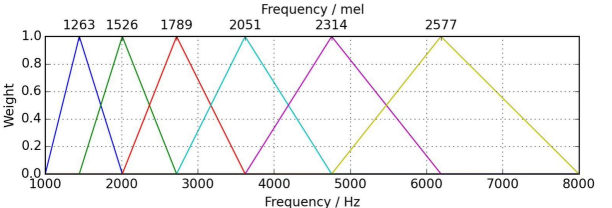

filter:滤波器是具有频率选择作用的电路(模拟滤波)或运算处理系统(数字滤波)，具有滤除噪声和分离各种不同信号的功能。按功能分：低通 高通 带通 带阻

最后应用triangular filters计算滤波器组(filter banks)，通常用40个滤波器nfilt=40 on a Mel-scale to the power spectrum to 提取频带(frequency bands). 

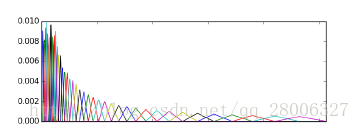

如上图所示，40个三角滤波器组成滤波器组，低频处滤波器密集，门限值大，高频处滤波器稀疏，门限值低。恰好对应了频率越高人耳越迟钝这一客观规律。上图所示的滤波器形式叫做**等面积梅尔滤波器（Mel-filter bank with same bank area）**，在人声领域（语音识别，说话人辨认）等领域应用广泛，但是如果用到非人声领域，就会丢掉很多高频信息。这时我们更喜欢的或许是**等高梅尔滤波器（Mel-filter bank with same bank height）**：

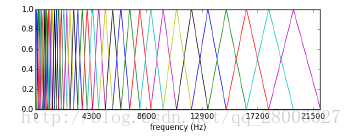

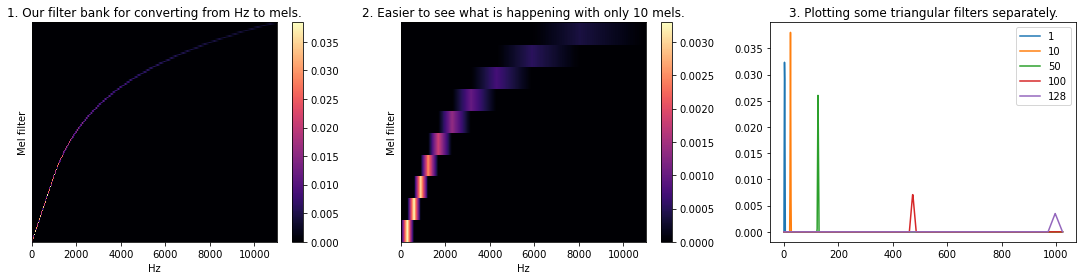

In [7]:
plt.figure(figsize=(15, 4));

plt.subplot(1, 3, 1);
librosa.display.specshow(mel, sr=sr, hop_length=hop_length, x_axis='linear');
plt.ylabel('Mel filter');
plt.colorbar();
plt.title('1. Our filter bank for converting from Hz to mels.');

plt.subplot(1, 3, 2);
mel_10 = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=10)
librosa.display.specshow(mel_10, sr=sr, hop_length=hop_length, x_axis='linear');
plt.ylabel('Mel filter');
plt.colorbar();
plt.title('2. Easier to see what is happening with only 10 mels.');

plt.subplot(1, 3, 3);
idxs_to_plot = [0, 9, 49, 99, 127]
for i in idxs_to_plot:
    plt.plot(mel[i]);
plt.legend(labels=['{}'.format(i+1) for i in idxs_to_plot]);
plt.title('3. Plotting some triangular filters separately.');

plt.tight_layout();

Now what does this give us?

Now we can take the amplitude of one time window, compute the dot product with mel to perform the tranformation, and get a visualization of the sound in this new frequency scale.

Text(0.5, 1.0, 'One sampled window for example, before and after converting to mel.')

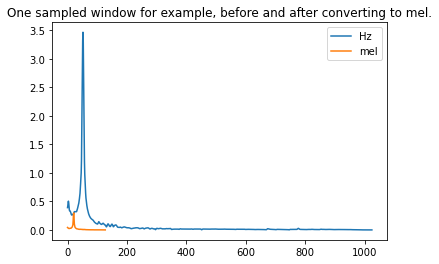

In [8]:
plt.plot(D[:, 1])
plt.plot(mel.dot(D[:, 1]))
plt.legend(labels=['Hz', 'mel'])
plt.title('One sampled window for example, before and after converting to mel.')

### The Mel Spectrogram

We know now what is a Spectrogram, and also what is the Mel Scale, so the Mel Spectrogram, is, rather surprisingly, a Spectrogram with the Mel Scale as its y axis.

And this is how you generate a Mel Spectrogram with one line of code, and display it nicely using just 3 more:

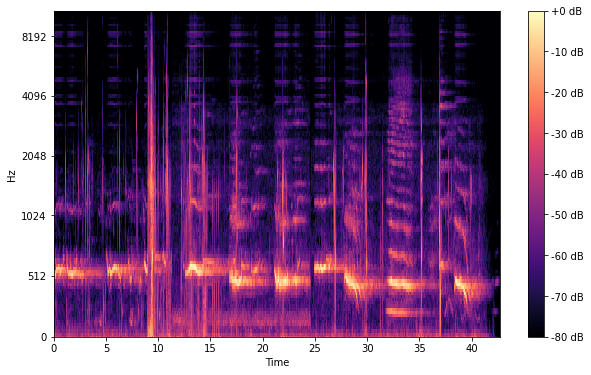

In [9]:
S = librosa.feature.melspectrogram(whale_song, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10, 6));
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

### Recap

**The Mel Spectrogram is the result of the following pipeline:**  

1. **Separate to windows:** Sample the input with windows of size n_fft=2048, making hops of size hop_length=512 each time to sample the next window.

2. **Compute FFT** for each window to transform from time domain to frequency domain.

3. **Generate a Mel scale:** Take the entire frequency spectrum, and separate it into n_mels=128 evenly spaced frequencies. And what do we mean by evenly spaced? not by distance on the frequency dimension, but distance as it heard by the human ear.

4. **Generate Spectrogram:** For each window, decompose the magnitude of the signal into its components, corresponding th the frequencies in the scale.

In [10]:
# Sanity check that indeed we understood the underlying pipeline

S = librosa.feature.melspectrogram(whale_song, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

fft_windows = librosa.stft(whale_song, n_fft=n_fft, hop_length=hop_length)
magnitude = np.abs(fft_windows)**2
mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)

assert (mel.dot(magnitude) == S).all()

### Filter banks, Mel-Frequency Cepstral Coefficients (MFCCs) and What's In-Between

Computing filter banks and MFCCs involve somewhat the same procedure, where in both cases filter banks are computed and with a few more extra steps MFCCs can be obtained.

In a nutshell(简而言之), a signal goes through a **pre-emphasis filter**; then gets **sliced into (overlapping) frames** and a window function is applied to each frame; afterwards, we do a **Fourier transform** on each frame (or more specifically a Short-Time Fourier Transform) and calculate **the power spectrum**; and subsequently **compute the filter banks**. To obtain MFCCs, a **Discrete Cosine Transform(DCT)** is applied to the filter banks retaining a number of the resulting coefficients while the rest are discarded. A final step in both cases, is **mean normalization**.